<a href="https://colab.research.google.com/github/monokim/BERT/blob/master/Intent_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Check If there is a GPU available.

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print(torch.cuda.get_device_name(0), 'will be used.')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
GeForce GTX 1060 will be used.


Select Dataset

In [2]:
import pandas as pd
import random

dataset = 'german' # imdb, agnews, chatbot, ubuntu, german
df = None
sentences = []
labels = []

language_model = 'bert_dbmdz' # bert, albert, roberta, xlnet, bert_german, bert_multi, bert_dbmdz
print(language_model + " model will be used")

bert_dbmdz model will be used


### IMDB Movie review Dataset
- 40,000 training samples
- 2 classes

In [3]:
if dataset == 'imdb':
    # Load the data set into a pandas dataframe
    df = pd.read_csv("./Dataset/IMDB_Dataset.csv", delimiter=',', header=None, names=['review', 'sentiment'])

    full_labels = df.sentiment.values
    full_labels = [1 if l == 'positive' else 0 for l in labels]
    full_sentences = df.review.values
    
    # Shuffle
    tmp = list(zip(full_sentences, full_labels))
    random.shuffle(tmp)
    full_sentences, full_labels = zip(*tmp)
    
    labels = full_labels[4000:]
    sentences = full_sentences[4000:]

### AG NEWS Dataset
- 120,000 training samples
- 7,600 test samples
- 4 classes

In [4]:
if dataset == 'agnews':
    # Load the data set into a pandas dataframe
    df = pd.read_csv("./Dataset/ag_news_train.csv", delimiter=',', header=None, names=['category', "head", 'content'])

    # Print number of sentences.
    labels = df.category.values - 1
    sentences = df.content.values

### Chatbot Corpus
    - 206 samples
    - 2 classes

In [5]:
if dataset == 'chatbot':
    # Load the data set into a pandas dataframe
    df = pd.read_json("./Dataset/ChatbotCorpus.json")
    text = df.sentences.values
    full_sentences = []
    full_labels = []
    for t in text:
        full_sentences.append(t['text'])
        label = t['intent']
        if label == 'FindConnection':
            full_labels.append(0)
        elif label == 'DepartureTime':
            full_labels.append(1)
    
    # Shuffle
    tmp = list(zip(full_sentences, full_labels))
    random.shuffle(tmp)
    full_sentences, full_labels = zip(*tmp)
    
    sentences = full_sentences[20:]
    labels = full_labels[20:]

### Ask Ubuntu corpus
- 162 samples
- 5 classes

In [6]:
if dataset == 'ubuntu':
    # Load the data set into a pandas dataframe
    df = pd.read_json("./Dataset/AskUbuntuCorpus.json")
    sentences = df.sentences.values
    full_sentences = []
    full_labels = []
    for s in sentences:
        full_sentences.append(s['text'])
        label = s['intent']
        if label == 'Make Update':
            full_labels.append(0)
        elif label == 'Setup Printer':
            full_labels.append(1)
        elif label == 'Shutdown Computer':
            full_labels.append(2)
        elif label == 'Software Recommendation':
            full_labels.append(3)
        elif label == 'None':
            full_labels.append(4)
    
    # Shuffle
    tmp = list(zip(full_sentences, full_labels))
    random.shuffle(tmp)
    full_sentences, full_labels = zip(*tmp)
    
    sentences = full_sentences[20:]
    labels = full_labels[20:]

### German Dataset
- 10kGNAD
- 9,245 training sample
- 9 classes

In [7]:
import csv

if dataset == 'german':
    # Load the data set into a pandas dataframe
    with open("./Dataset/german_train.csv",  "r", encoding='utf-8',) as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar='\'')
        for row in reader:
            if row[0] == 'Web':
                label = 0
            elif row[0] == 'International':
                label = 1
            elif row[0] == 'Etat':
                label = 2
            elif row[0] == 'Wirtschaft':
                label = 3
            elif row[0] == 'Panorama':
                label = 4
            elif row[0] == 'Sport':
                label = 5
            elif row[0] == 'Wissenschaft':
                label = 6
            elif row[0] == 'Kultur':
                label = 7
            elif row[0] == 'Inland':
                label = 8
            
            labels.append(label)
            sentences.append(row[1])

Training Sample

In [8]:
print("Training size : %d" % len(labels))
print(sentences[:5])
print(labels[:5])

Training size : 9245


['21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.', 'Erfundene Bilder zu Filmen, die als verloren gelten: "The Forbidden Room" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur All

[5, 7, 0, 3, 8]


# BERT Tokenizer

### Tokenize each words and convert to token IDs

In [9]:
# Install transformers by using pip
!pip install transformers

In [10]:
from transformers import BertTokenizer
from transformers import AlbertTokenizer
from transformers import RobertaTokenizer
from transformers import XLNetTokenizer

# Load BERT Tokenizer
if language_model == 'bert':
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif language_model == 'bert_german':
    tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased', do_lower_case=True)
elif language_model == 'bert_multi':
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
elif language_model == 'bert_dbmdz':
    tokenizer = BertTokenizer.from_pretrained('bert-base-german-dbmdz-cased', do_lower_case=True)
    
elif language_model == 'albert':
    tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
elif language_model == 'roberta':
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
elif language_model == 'xlnet':
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

print('Original : ', sentences[0])
print('Tokenized : ', tokenizer.tokenize(sentences[0]))
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original :  21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.
Tokenized :  ['21', '-', 'jahr', '##iger', 'fal', '##lt', 'wohl', 'bis', 'saison', '##ende', 'aus', '.', 'wie', '##n', '–', 'ra', '##pid', 'muss', 'wohl', 'bis', 'saison', '##ende', 'auf', 'offen', '##siv', '##spieler', 'th', '##omas', 'mu', '##rg', 'verzichten', '.', 'der', 'im', 'win', '##ter', 'aus', 'rie', '##d', 'gekommen', '##e', '21', '-', 'jahr', '##ige', 'erlitt', 'beim', '0', ':', '4', '-', 'heim', '##deb', '##akel', 'gegen', 'ad', '##mir', '##a', 'wa', '##cker', 'mod', '##ling', 'am', 'sam', '##stag', 'einen', 'teil', '##r

### Sentence to ID

In [11]:
input_ids = []

for s in sentences:
    encoded_sentence = tokenizer.encode(s, max_length = 512, add_special_tokens=True)
    input_ids.append(encoded_sentence)
    
print('original: ', sentences[0])
print('id: ', input_ids[0])
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

original:  21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.
id:  [102, 1735, 232, 9453, 693, 4682, 547, 2134, 378, 22522, 1071, 260, 566, 335, 30882, 809, 1919, 21326, 1092, 2134, 378, 22522, 1071, 216, 1872, 13640, 3680, 1773, 3283, 8130, 12438, 12698, 566, 125, 223, 16367, 162, 260, 10136, 30888, 3977, 30881, 1735, 232, 9453, 435, 16583, 916, 430, 853, 470, 232, 6005, 13155, 17171, 574, 3668, 11609, 30887, 12805, 2009, 11219, 3587, 339, 23156, 929, 397, 1418, 9744, 222, 12197, 4614, 115, 223, 7923, 6274, 110, 818, 335, 261, 27016, 3029, 18487, 232, 5033, 213, 132, 339, 17925, 2676, 12616, 56

### Add padding and attention masks

In [12]:
def add_padding_and_truncate(input_ids):
    MAX_LEN = 64
    for index, input_id in enumerate(input_ids):
        for i in range(MAX_LEN - len(input_id)):
          input_id.insert(0, 0)
        if len(input_id) > MAX_LEN:
          input_ids[index] = input_id[:MAX_LEN]


In [13]:
# Fit sentence's length to MAX_LEN
add_padding_and_truncate(input_ids)

print('After max question length: ', max([len(id) for id in input_ids]))

attention_masks = []

for id in input_ids:
    att_mask = [int(token_id > 0) for token_id in id]
    attention_masks.append(att_mask)

After max question length:  64


In [14]:
from sklearn.model_selection import train_test_split

train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)
train_masks, valid_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = RandomSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

# Training

### Select classification model

In [16]:
from transformers import BertForSequenceClassification, BertConfig
from transformers import AlbertForSequenceClassification, AlbertConfig
from transformers import RobertaForSequenceClassification, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetConfig

num_label = max(labels) + 1
print("Number of labels : %d" % num_label)

if language_model == 'bert':
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels = num_label, 
        output_attentions = False,
        output_hidden_states = False
    )
elif language_model == 'bert_german':
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-german-cased',
        num_labels = num_label, 
        output_attentions = False,
        output_hidden_states = False
    )
elif language_model == 'bert_multi':
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-multilingual-cased',
        num_labels = num_label, 
        output_attentions = False,
        output_hidden_states = False
    )
elif language_model == 'bert_dbmdz':
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-german-dbmdz-cased',
        num_labels = num_label, 
        output_attentions = False,
        output_hidden_states = False
    )
    
elif language_model == 'albert':
    model = AlbertForSequenceClassification.from_pretrained(
        'albert-base-v2',
        num_labels = num_label,
        output_attentions = False,
        output_hidden_states = False
    )
elif language_model == 'roberta':
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels = num_label,
        output_attentions = False,
        output_hidden_states = False
    )
elif language_model == 'xlnet':
    model = XLNetForSequenceClassification.from_pretrained(
        'xlnet-base-cased',
        num_labels = num_label,
    )

if device.type == 'cuda':
  model.cuda()

Number of labels : 9


In [17]:
from transformers import get_linear_schedule_with_warmup, AdamW

optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

epochs = 4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [18]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [20]:
import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them
loss_values = []

t_total = time.time()
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear previously calculated gradients
        model.zero_grad()        

        # Perform a forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        # Returns a tuple
        loss = outputs[0]

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent gradient explode
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate and store the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # For each batch of validation data
    for batch in valid_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # No computing or storing gradients
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

        
    print("  Accuracy: {0:.3f}".format(eval_accuracy / nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("Training took: {:}".format(format_time(time.time() - t_total)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    260.    Elapsed: 0:00:29.
  Batch    80  of    260.    Elapsed: 0:00:58.
  Batch   120  of    260.    Elapsed: 0:01:27.
  Batch   160  of    260.    Elapsed: 0:01:56.
  Batch   200  of    260.    Elapsed: 0:02:25.
  Batch   240  of    260.    Elapsed: 0:02:54.

  Average training loss: 0.981
  Training epoch took: 0:03:09

Running Validation...
  Accuracy: 0.841
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    260.    Elapsed: 0:00:30.
  Batch    80  of    260.    Elapsed: 0:01:00.
  Batch   120  of    260.    Elapsed: 0:01:29.
  Batch   160  of    260.    Elapsed: 0:01:59.
  Batch   200  of    260.    Elapsed: 0:02:29.
  Batch   240  of    260.    Elapsed: 0:02:59.

  Average training loss: 0.473
  Training epoch took: 0:03:14

Running Validation...
  Accuracy: 0.860
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    260.    Elapsed: 0:00:31

### Plot

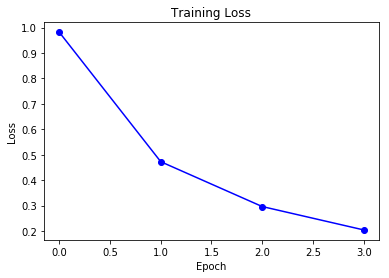

In [24]:
import matplotlib.pyplot as plt

plt.plot(loss_values, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Test

### Select Dataset

In [22]:
import pandas as pd

sentences = []
labels = []

if dataset == 'imdb':
    sentences = df.review.values[1:4000]
    labels = df.sentiment.values[1:4000]
    
elif dataset == 'agnews':
    df = pd.read_csv("./Dataset/ag_news_test.csv", delimiter=',', header=None, names=['category', "head", 'content'])
    sentences = df.content.values
    labels = df.category.values - 1

elif dataset == 'chatbot':
    sentences = full_sentences[:20]
    labels = full_labels[:20]

elif dataset == 'ubuntu':
    sentences = full_sentences[:20]
    labels = full_labels[:20]

elif dataset == 'german':
    with open("./Dataset/german_test.csv",  "r", encoding='utf-8',) as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar='\'')
        for row in reader:
            if row[0] == 'Web':
                label = 0
            elif row[0] == 'International':
                label = 1
            elif row[0] == 'Etat':
                label = 2
            elif row[0] == 'Wirtschaft':
                label = 3
            elif row[0] == 'Panorama':
                label = 4
            elif row[0] == 'Sport':
                label = 5
            elif row[0] == 'Wissenschaft':
                label = 6
            elif row[0] == 'Kultur':
                label = 7
            elif row[0] == 'Inland':
                label = 8

            labels.append(label)
            sentences.append(row[1])

### Test

In [23]:
print("Test size : %d" % len(labels))
t0 = time.time() 

if language_model == 'xlnet':
    sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

input_ids = []

for s in sentences:
    encoded_sentence = tokenizer.encode(s, max_length = 512, add_special_tokens=True)
    input_ids.append(encoded_sentence)
        
add_padding_and_truncate(input_ids)

attention_masks = []

for id in input_ids:
    att_mask = [int(token_id > 0) for token_id in id]
    attention_masks.append(att_mask)
    
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

model.eval()

eval_accuracy = 0
eval_steps = 0
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    eval_accuracy += flat_accuracy(logits, label_ids)
    eval_steps += 1

print("Accuracy: {0:.3f}".format(eval_accuracy / eval_steps))
print("Validation took: {:}".format(format_time(time.time() - t0)))
print("Done")

Test size : 1028
Accuracy: 0.850
Validation took: 0:00:19
Done
